# Piecewise solutions to the linear acyclic network 

The solution representing the relative contribution of species $j$ to species $i$ across some chain of N vertices is given in terms of the Laplace transform coordinate $s$ as:

\begin{gather}
G_{ij}(s) = \frac{\prod_{i=1}^N \alpha_i}{\prod_{j=1}^{N-1} (s+\alpha_j)}
\end{gather}

which by solving the Bromwhich integral becomes the familiar $G_{ij}(\tau)$. 

Now since $s \sim \frac{1}{\tau}$ once $\tau$ becomes large there will be some $\alpha_k$ such that $s \ll \alpha_k$. In this situation the $\alpha_k$ can be pulled out of the denominator to give:
\begin{gather}
G_{ij}(s) = \frac{\prod_{i=1}^N \alpha_i}{\alpha_{k}\prod_{j\neq k=1}^{N-2} (s+\alpha_j)}
\end{gather}
Which will be accurate for some range of $\tau$. 

## Obtaining the piecewise solutions

We begin by defining two functions: one to calculate the $G_{ij}(\tau)$ and one to mediate the transfer between the piecewise solutions:

In [1]:
import sys
!{sys.executable} -m pip install --quiet wnpoly
from scipy.integrate import solve_ivp
import numpy as np
import math
import wnpoly as wp
from scipy.stats import gmean
import matplotlib.pyplot as plt
from scipy.special import gammaln

In [6]:
def get_poly(sigma, order):
    s = wp.symm.Complete()
    bell = wp.bell.Bell()
    h = s.compute_normalized(sigma, order)
    x = bell.invert(h)
    return h, x 
    
def get_fbar(sigma):
    sig_max = max(sigma)
    return [(sig_max - sigs)/sig_max for sigs in sigma]

def G_piecewise(tau, sigma):
    if max(sigma)*tau >=100:
        sigs = [x for x in sigma if x<max(sigma)]
    else:
        sigs = sigma
    max_sig = max(sigs)
    sig = gmean(sigs)
    fbar = get_fbar(sigs)
    h, x = get_poly(fbar, 5)
    result = 0 
    m = len(sigs)
    for i in range(len(x)):
        result += x[i] * (max_sig*tau)**(i) * 1/(math.factorial(i))
    return np.exp((m-1)*np.log(sig*tau) - gammaln(m) - max(sigma)*tau + result)

def G_bell(tau, sigma, N):
    f_bar = get_fbar(sigma)
    m = len(sigma)
    sig = gmean(sigma)
    h, x = get_poly(f_bar, N)
    max_sig = max(sigma)
    result = 0 
    for i in range(N):
        result += x[i] * (max_sig*tau)**(i) * 1/(math.factorial(i))
    return np.exp((m-1)*np.log(sig*tau) - gammaln(m) - max(sigma)*tau + result)

def Y(t, y, sigs):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigs[0]*y[0]
    for i in range(1, N):
        result[i] = sigs[i-1]*y[i-1] - sigs[i]*y[i]
    return result

<ipython-input-6-6da6bc977f6a>:36: RuntimeWarning: overflow encountered in exp
  return np.exp((m-1)*np.log(sig*tau) - gammaln(m) - max(sigma)*tau + result)
<ipython-input-6-6da6bc977f6a>:25: RuntimeWarning: overflow encountered in exp
  return np.exp((m-1)*np.log(sig*tau) - gammaln(m) - max(sigma)*tau + result)


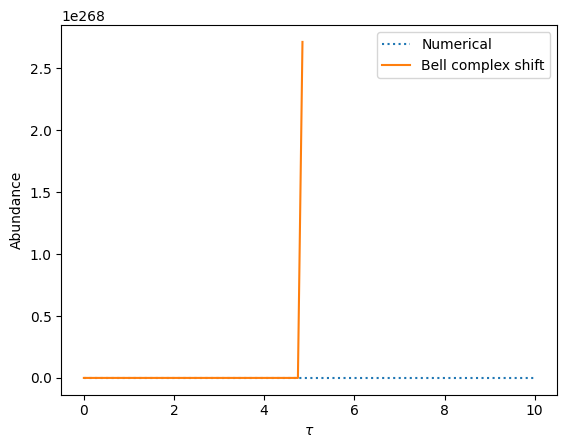

In [10]:
sigma = [1,1,5,1]

ys = np.zeros(len(sigma))
ys[0] = 1

tau = np.linspace(0.001, 10, 100)
g_bell = np.zeros((len(tau), len(ys), len(ys)))
g_bell_pw = np.zeros((len(tau), len(ys), len(ys)))
for t in range(len(tau)):
    for i in range(len(ys)):
        for j in range(len(ys)):
            if j<=i:
                sig_array = sigma[j:i+1]
                g_bell[t][i,j] = G_bell(tau[t], sig_array, 10)
                g_bell_pw[t][i,j] = G_piecewise(tau[t], sig_array)
                
y_b_final = np.zeros([len(tau), len(ys)])
y_b_final_pw = np.zeros([len(tau), len(ys)])
for t in range(len(tau)):
    y_b_final[t] = np.dot(g_bell[t], ys)
    y_b_final_pw[t] = np.dot(g_bell_pw[t], ys)

sol = solve_ivp(Y, [0, tau[len(tau)-1]], ys, args=(sigma,), max_step=0.02)

#plot results
plt.plot(sol.t, sol.y[2], ':', label='Numerical')
plt.plot(tau, y_b_final[:,2], label = 'Bell complex shift')
#plt.plot(tau, y_b_final_pw[:,2], label = 'Bell complex shift, piecewise soln')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel('Abundance')
plt.show()